In [1]:
import numpy as np
from matplotlib import pyplot as plt

E = np.identity

In [2]:
EPS = 1e-10

Butcher table:

In [3]:
A = np.array([
    [1/4,       0,         0,         0,         0,         ],
    [1/2,       1/4,       0,         0,         0,         ],
    [17/50,    -1/25,      1/4,       0,         0,         ],
    [371/1360, -137/2720,  15/544,    1/4,       0,         ],
    [25/24,    -49/48,     125/16,   -85/12,     1/4,       ],
])

b = np.array([25/24, -49/48, 125/16, -85/12, 1/4])
c = np.array([1/4, 3/4, 11/20, 1/2, 1])
S = A.shape[0]

assert len(A.shape) == 2
assert A.shape[0] == A.shape[1]
S = A.shape[0]
assert len(b) == S
assert len(c) == S

## Approximation

Kutta condition:

In [4]:
np.linalg.norm(A.sum(axis=1) - c) < EPS

True

$p \ge 1$:

In [5]:
abs(b.sum() - 1) < EPS

True

$p \ge 2$:

In [6]:
abs((b * c).sum() - 0.5) < EPS

True

$p \ge 3$:

In [7]:
abs((b * c ** 2).sum() - 1/3) < EPS

True

In [8]:
abs((b[:, np.newaxis] * A * c[np.newaxis, :]).sum() - 1/6) < EPS

True

$p \ge 4$:

In [9]:
abs((b * c ** 3).sum() - 1/4) < EPS

True

In [10]:
abs((b * c *(A * c[np.newaxis, :]).sum(axis=1)).sum() - 1/8) < EPS

True

In [11]:
abs((b[:, np.newaxis] * A * c[np.newaxis, :] ** 2).sum() - 1/12) < EPS

True

In [12]:
abs((b[:, np.newaxis] * A @ A * c[np.newaxis]).sum() - 1/24) < EPS

True

## Stability

Stability function:

In [13]:
def R(z):
    return abs(
        np.linalg.det(E(A.shape[0]) - z * (A - b[np.newaxis, :])) / 
        np.linalg.det(E(A.shape[0]) - z * A)
    )

In [14]:
R = np.vectorize(R)

In [15]:
def complex_contour_plot(Re, Im, f, levels=100, cmap='viridis'):
    F = f(Re[np.newaxis, :] + 1j * Im[:, np.newaxis])
    plt.figure(figsize=(15, 10))
    plt.contourf(Re, Im, F, levels=levels, cmap=cmap)
    plt.colorbar()
    plt.grid()
    plt.xlabel('$\operatorname{Re}{z}$')
    plt.ylabel('$\operatorname{Im}{z}$')

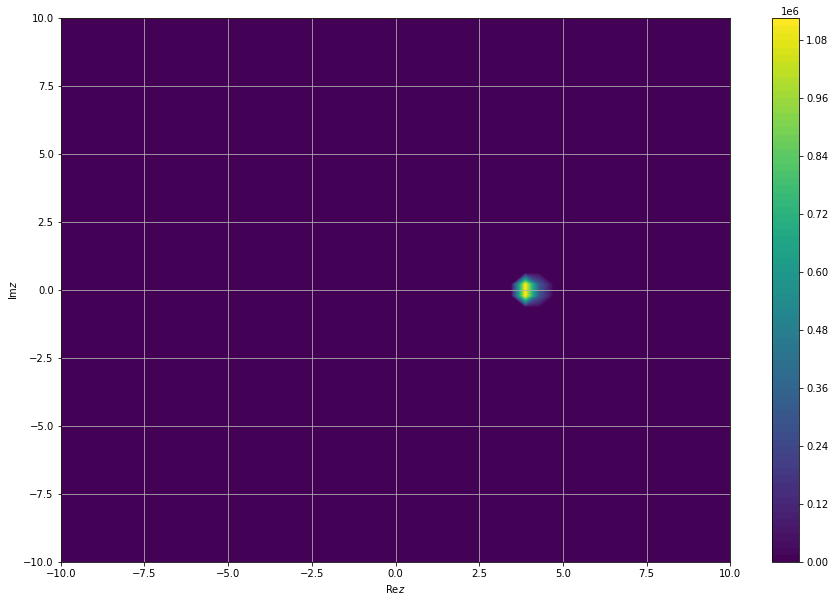

In [16]:
complex_contour_plot(np.linspace(-10, 10), np.linspace(-10, 10), R)

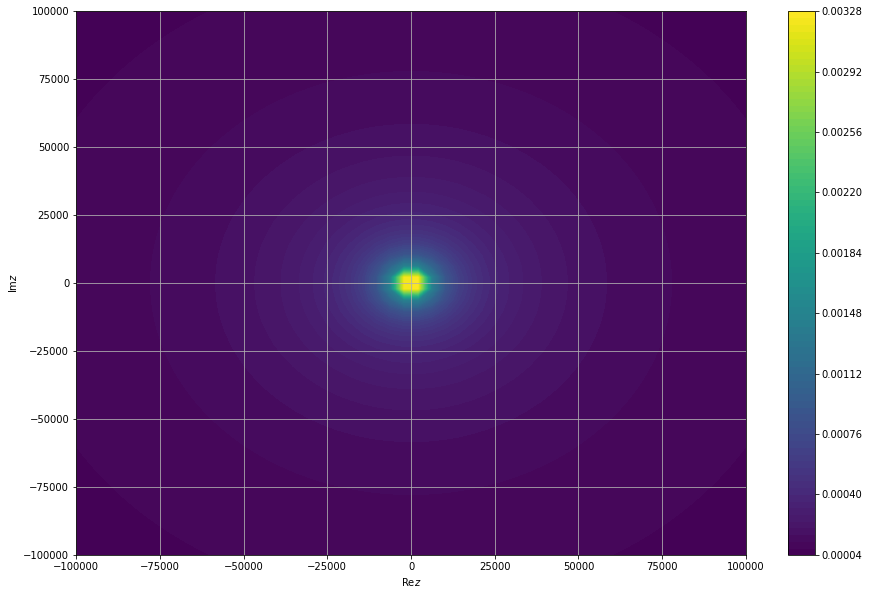

In [17]:
complex_contour_plot(np.linspace(-100000, 100000), np.linspace(-100000, 100000), R)

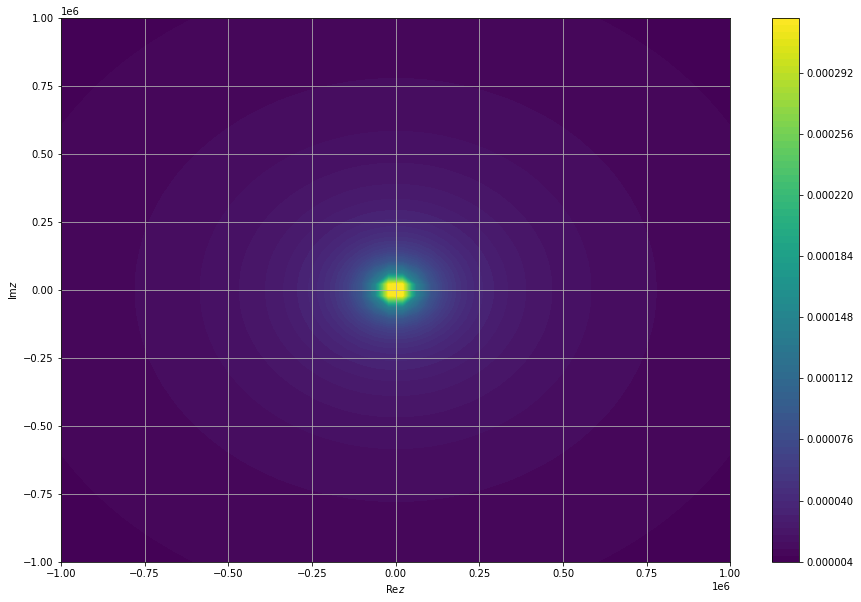

In [18]:
complex_contour_plot(np.linspace(-1e6, 1e6), np.linspace(-1e6, 1e6), R)

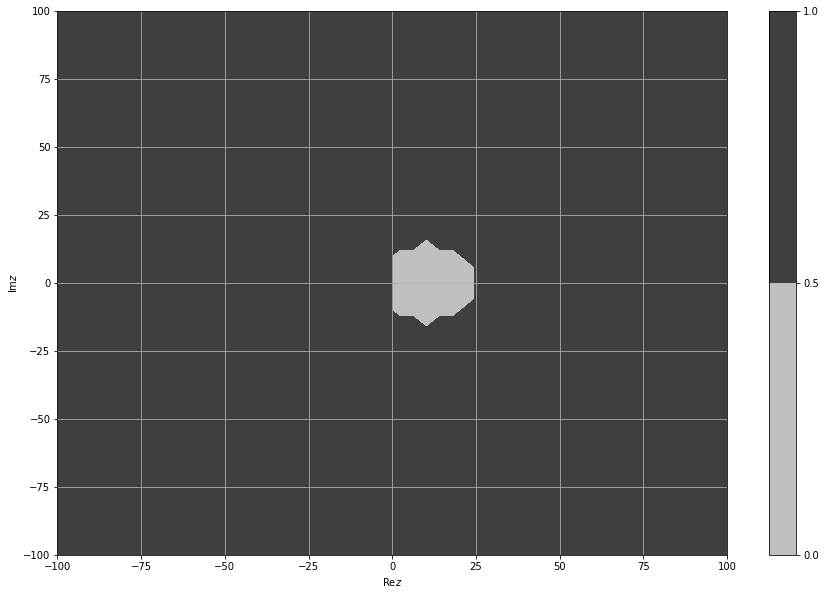

In [19]:
complex_contour_plot(np.linspace(-100, 100), np.linspace(-100, 100), lambda x: R(x) <= 1, levels=1, cmap='binary')

## ODE system

### General

$\begin{cases}
    \vec{y}' = \vec{f}(x, \vec{y}) \\
    \vec{y}(x_0) = \vec{y_0}
\end{cases}$

### Test

$\begin{cases}
    ! \\
    y(0) = 0 \\
    y'(0) = 1
\end{cases}$

$\begin{cases}
    y_0' = y_1 \\
    y_1' = -y_0 + x + 1 \\
    y_0(0) = 0 \\
    y_1(0) = 1
\end{cases}$

$\begin{cases}
    y(x) = y_0(x) = (2 x - 3) e^x + x + 3 \\
    y'(x) = y_1(x) = (2 x - 1) e^x + 1
\end{cases}$


In [20]:
N = 2

In [21]:
def f(x, y):
    F = np.array([[0, 1],
                  [-1, 2]])
    return F @ y + np.array([0, x + 1])

def df_dx(x, y):
    return np.array([0, 1])

def d2f_dx2(x, y):
    return np.zeros(2)

def df_dy(x, y):
    F = np.array([[0, 1],
                  [-1, 2]])
    return F
    
def d2_d2y(x, y):
    return np.zeros((2, 2, 2))

assert (f(0, [0, 0]) == [0, 1]).all()
assert (f(1, [0, 0]) == [0, 2]).all()
assert (f(0, [1, 0]) == [0, 0]).all()
assert (f(0, [0, 1]) == [1, 3]).all()

In [22]:
def y_true(x):
    return np.array([
        (2 * x - 3),
        (2 * x - 1)
    ]) * np.exp(x) + np.array([
        x + 3,
        1
    ])

def dy_true_dx(x):
    return np.array([
        (2 * x - 1),
        (2 * x + 1)
    ]) * np.exp(x) + np.array([1, 0])

assert (y_true(0) == [0, 0]).all()
assert abs(dy_true_dx(0) - f(0, y_true(0))).sum() < EPS
assert abs(dy_true_dx(1) - f(1, y_true(1))).sum() < EPS
assert abs(dy_true_dx(2) - f(2, y_true(2))).sum() < EPS
assert abs(dy_true_dx(3) - f(3, y_true(3))).sum() < EPS

## Grid

In [23]:
n = 401
x_0 = 0
x_1 = 2
h = (x_1 - x_0) / (n - 1)
x = np.linspace(x_0, x_1, n)

assert x.shape[0] == n
assert x[0] == x_0
assert x[n - 1] == x_1
assert abs(x[1] - x[0] - h) < EPS

In [24]:
y_0 = [0, 0]
y = np.zeros((n, N))
y[0] = y_0

## Test (Euler's method)

$y'_i \sim \dfrac{y_{i + 1} - y_i}{h}\$ 

In [25]:
for i in range(n - 1):
    y[i + 1] = y[i] + h * f(x[i], y[i])

In [26]:
def compare(y, y_true, x):
    for i in range(N):
        plt.figure(figsize=(10, 5))
        plt.title('Solution')
        plt.plot(x, y[:, i], label=f'y_{i}')
        plt.plot(x, [y_true(x_j)[i] for x_j in x], label=f'y_{i}_true')
        plt.legend()
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('y')
        
        
        plt.figure(figsize=(10, 5))
        plt.title('Difference')
        plt.plot(x, abs(y[:, i] - [y_true(x_j)[i] for x_j in x]), label=f'|y_{i} - y{i}_true|')
        plt.legend()
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('y')

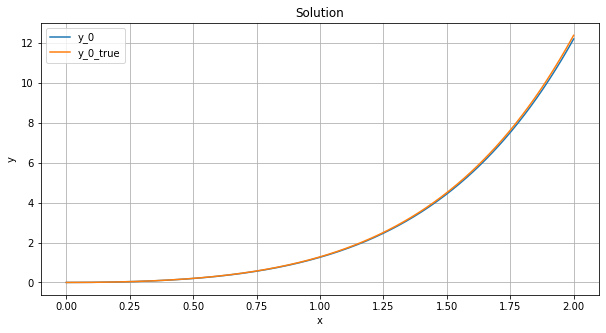

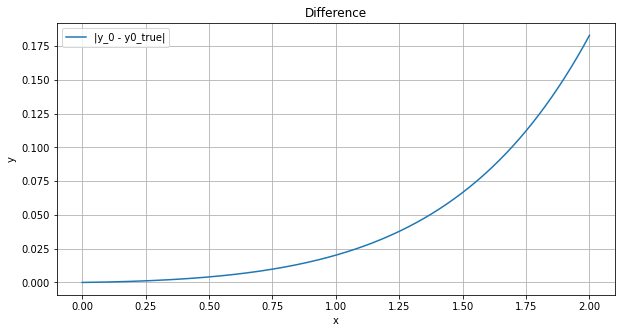

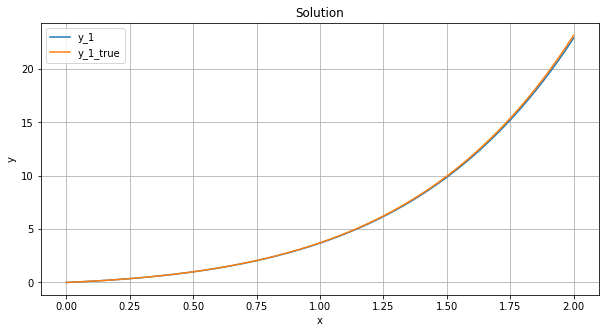

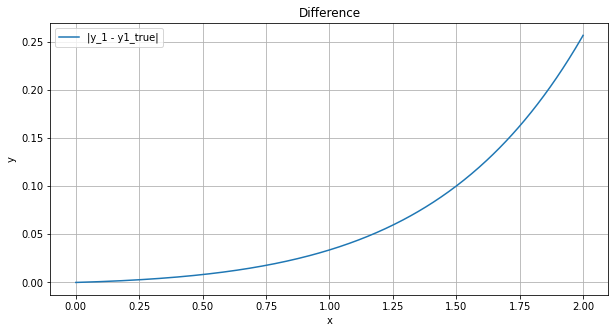

In [27]:
compare(y, y_true, x)

In [28]:
y_Euler = y.copy()

## Implicit equations

$$
\vec{y}_{n+1} = \vec{y}_n + h \sum_{i=1}^s b_i \vec{f_i} \\
\vec{f_i} = \vec{f}(x_n + h c_i, \vec{y_n} + h \sum_{j=1}^s a_{ij} \vec{f_j}),~i = 1, 2,~...~ s \\
$$

$$
\mathbf{F}(\vec{f}) = \mathbf{0}
$$

$$
\vec{F}_i(\vec{f}) = \vec{f}(x_n + h c_i, \vec{y}_n + h \sum_{j=1}^s a_{ij} \vec{f_j}) - \vec{f}_i,~i = 1, 2,~...~ s
$$

Vectorize $\mathbf{F}$:

$$
\vec{F} = (\vec{F}_i^T)^T
$$

$$
\vec{F}(\vec{f}) = \vec{0}
$$


### Newton's method:

$$
\vec{f}_{n+1} = \vec{f}_{n} - \left(\frac{\partial \vec{F}(\vec{f}_n)}{\partial \vec{f}}\right)^{-1} \times \vec{F}(\vec{f}_n)
$$


In [29]:
from scipy.optimize import newton_krylov

In [30]:
def RK(y_n, x_n, h, f, A, b, c, n_iter = 10, tol = 0.01):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    S = A.shape[0]
    assert b.shape == (S,)
    assert c.shape == (S,)
    
    N = len(y_n)
    assert len(f(x_n, y_n)) == N
    
    f_0 = np.repeat(f(x_n, y_n)[np.newaxis, ...], S, axis=0)
    assert f_0.shape == (S, N)
    
    ## Make F vector-function
    f_0 = f_0.flatten()
    def F(f_):
        return np.array([
            f(x_n + h * c[i],
              y_n + h * sum(A[i, j] * f_[i * N: (i + 1) * N]
                      for j in range(S)))
            for i in range(S)
        ]).flatten() - f_
    f_n = newton_krylov(F, f_0, iter=n_iter, x_tol=tol)
    return y_n + h * f_n.reshape(S, N).T @ b    

In [31]:
for i in range(n - 1):
    y[i + 1] =  RK(y[i], x[i], h, f, A, b, c, n_iter = None, tol = None)

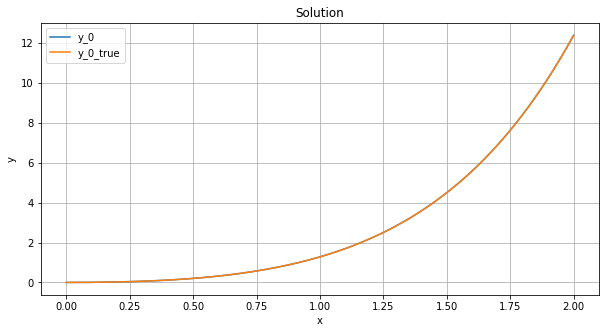

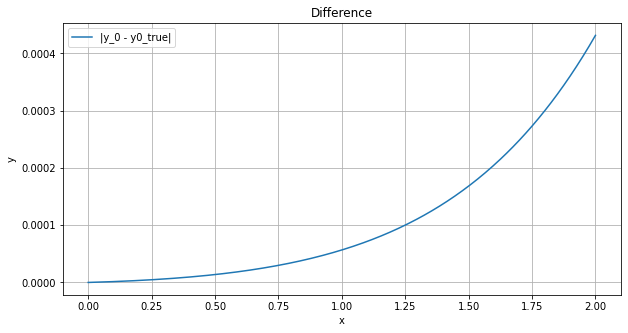

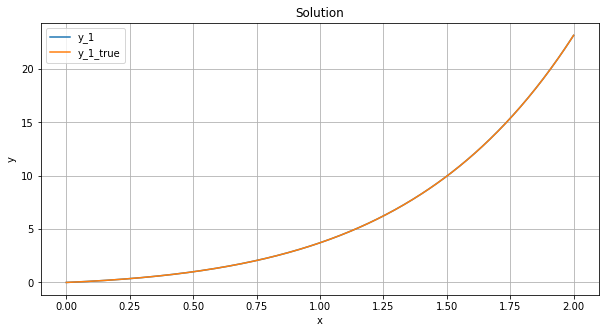

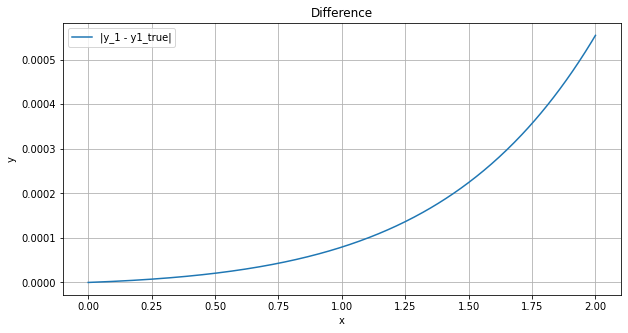

In [32]:
compare(y, y_true, x)

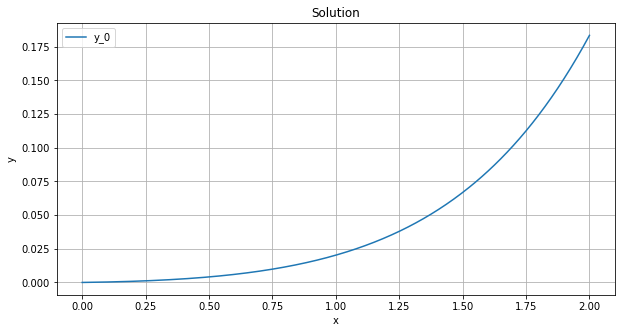

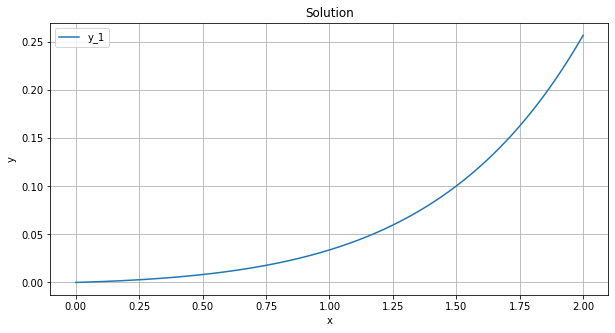

In [33]:
for i in range(N):
    plt.figure(figsize=(10, 5))
    plt.title('Solution')
    plt.plot(x, y[:, i] - y_Euler[:, i], label=f'y_{i}')
    plt.legend()
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')